In [25]:
from scipy import stats
import csv 
import sys
import os
sys.path.append("..")
import matplotlib.pyplot as plt
import random
import numpy as np
import math
from astropy.io import fits

from functions import open_csv, separete_csv, both_array_sigma

# パラメーターを設定する

* threshold : 赤化が顕著になり始める時のr-iバンドの値(下の方にあるグラフでいう横線)
* base_value : 赤化が発生しなければこれくらいになるであろうと想像されるg-rバンドの値(下の方にあるグラフでいう縦線)
* interval : 分割する正方形のグリッドの大きさ(赤経赤緯)

In [26]:
threshold = 0.5
base_value = 0
interval = 0.01
fits_file_name = 'sample.fits'

# データを開く

In [32]:
datapath = '../data/23_48_50_+21_44_00.csv'


all_datas = open_csv(datapath)
sep_datas, keys = separete_csv(all_datas)

# データの中から必要なものを取り出す

今回は，座標(RADEG,DEDEG), バンドの値(G_BAND, R_BAND, I_BAND)を取り出す

In [33]:
RAdegs = []
DEdegs = []
All_Bands = []
formatted_data = []

#適当な初期値
ramin = 400
ramax = 0
demin = 400
demax = 0
for data in sep_datas:
    #最大/小値を探索
    if ramin > float(data[keys["RAdeg"]]):
        ramin = float(data[keys["RAdeg"]])
    if ramax < float(data[keys["RAdeg"]]):
        ramax = float(data[keys["RAdeg"]])
    if demin > float(data[keys["DEdeg"]]):
        demin = float(data[keys["DEdeg"]])
    if demax < float(data[keys["DEdeg"]]):
        demax = float(data[keys["DEdeg"]])
        
    try: #どれかのデータがからになることがあるのでTryにする
        RAdegs.append(float(data[keys["RAdeg"]]))
        DEdegs.append(float(data[keys["DEdeg"]]))
        #データが消えることがあるのでこのようにまとめておく
        All_Bands.append([float(data[keys["gmag"]]),float(data[keys["rmag"]]),float(data[keys["imag"]])])
    except:
        pass



In [34]:
ramin = math.floor(ramin) 
ramax = math.floor(ramax) + 1 #ギリギリのデータが蹴られてしまうため
demin = math.floor(demin) 
demax = math.floor(demax) + 1 #ギリギリのデータが蹴られてしまうため"

In [35]:
print(ramin, ramax, demin, demax, sep = "_")

0_360_16_27


# データの軸を入れ替える

現在は，0次元目に星が入り，1次元目に3バンドの値が入っている．つまり，ある一つの星について，3バンドの値がまとめて納められている．しかし，これでは処理が大変なので転置を使って改善する．

``` sample
# 今
[[23, 42, 21], [3, 1, 5], [2, 5, 1], [6, 1, 7]]

# この処理の後
[[23, 3, 2, 6], [42, 1, 5, 1], [21, 5, 1, 7]]
```

In [36]:
G_Bands = []
R_Bands = []
I_Bands = []
All_Bands = np.array(All_Bands).T
G_Bands = All_Bands[0]
R_Bands = All_Bands[1]
I_Bands = All_Bands[2]
R_Bands = np.array(R_Bands)
G_Bands = np.array(G_Bands)
I_Bands = np.array(I_Bands)

# 外れ値処理をする前のグラフを書いてみる

[]

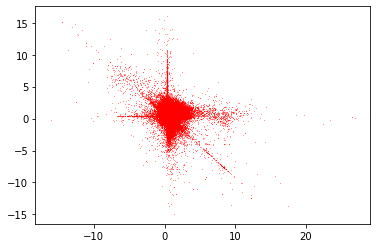

In [8]:
G_R_Array = G_Bands - R_Bands
R_I_Array = R_Bands - I_Bands

plt.scatter(G_R_Array,R_I_Array, s=0.01, c = 'red',marker='x')
plt.plot()

# Sigma-clippingというものを使って外れ値処理をする

実装についてはfunctions.pyを参考にしていただきたい．

In [9]:
Clipped_G_R_Array, Clipped_R_I_Array = both_array_sigma(G_R_Array, R_I_Array, n = 3)

# グラフに書いてみる

縦線はbase_value 横線はThreshoidです

[]

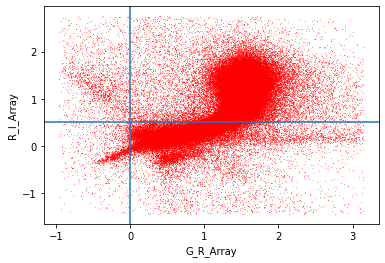

In [10]:
plt.scatter(Clipped_G_R_Array, Clipped_R_I_Array, s=0.01, c = 'red',marker='x')
plt.xlabel('G_R_Array')
plt.ylabel('R_I_Array')
plt.axvline(x=base_value, ymin=np.amin(Clipped_R_I_Array), ymax=np.amax(Clipped_R_I_Array))
plt.axhline(y=threshold, xmin=np.amin(Clipped_G_R_Array), xmax=np.amax(Clipped_G_R_Array))
plt.plot()

# 条件を満たす星の座標を得る

R-Iバンドの値がthresholdよりも大きい星のG-Rバンドが赤化の影響を受けるので，その星を調べる．
上のグラフでいうと，横線より上にある星を求めています．

In [11]:
preprocess_address = np.where(Clipped_R_I_Array > threshold)

# 条件を満たす星のG_Rバンドの値を得る

In [12]:
reddening_values = Clipped_G_R_Array[preprocess_address]

# グリッドを用いた分割のためにデータを整頓する

条件を満たす星の座標(赤経赤緯)を求めています．

In [13]:
reddening_RAdegs = np.array(RAdegs)[preprocess_address]
reddening_DEdegs = np.array(DEdegs)[preprocess_address]

# 赤化量を求める

In [14]:
d_reddening = reddening_values - base_value

# 分割のためにデータが全て収まるメッシュを作る

In [15]:
RAaxis = np.arange(ramin, ramax, interval)
DEaxis = np.arange(demin, demax, interval)
print("shape of result is " + str(len(RAaxis) - 1) +  " * " + str(len(DEaxis) - 1))

shape of result is 35999 * 1099


# 分割して各グリッドの赤化の平均値を求める

scipyという魔法道具を使っています．Docsに解説が書いてあります．

In [16]:
ret = stats.binned_statistic_2d(reddening_RAdegs, reddening_DEdegs, d_reddening , 'mean', bins=[RAaxis, DEaxis])

# Nanが混じっているので処理する

In [17]:
result_array = np.nan_to_num(ret.statistic)

# Fitsにエクスポートする

こちらに下準備がすんだヘッダーになります．

In [18]:
hdr = fits.Header()
primary_hdu = fits.PrimaryHDU(header = hdr)
image_hdu = fits.ImageHDU(result_array)
hdul = fits.HDUList([primary_hdu, image_hdu])
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 ImageHDU         7   (1099, 35999)   float64   


# ヘッダーを調理していきます

In [19]:
width = len(RAaxis) - 1
height = len(DEaxis) - 1

refx = width / 2
refy = height / 2

#これはこのcsvデータの固定値です．
lng = 358.458333
lat = -21.583333

hbet = interval
hdul[0].header['NAXIS'] = (2, 'Two dimensional image')
hdul[0].header['Creater'] = ('08 Toru', 'Superman')
hdul[0].header['Comment'] = 'Sourcefilename : ' + datapath
hdul[0].header['NAXIS1'] = (width , 'Width of image')
hdul[0].header['NAXIS2'] = (height , 'Height of image')
hdul[0].header['CRVAL1'] = (lng , 'Reference longitude')
hdul[0].header['CRVAL2'] = (lat , 'Reference latitude')
hdul[0].header['CTYPE1'] = ('RA---TAN' , 'Coordinates -- projection')
hdul[0].header['CTYPE2'] = ('DEC--TAN' , 'Coordinates -- projection')
hdul[0].header['CRPIX1'] = (refx , 'X reference pixel')
hdul[0].header['CRPIX2'] = (refy , 'Y reference pixel')
hdul[0].header['CDELT1'] = (hbet , 'X scale')
hdul[0].header['CDELT2'] = (hbet , 'Y scale')

header = hdul[0]

In [20]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / Two dimensional image                          
EXTEND  =                    T                                                  
CREATER = '08 Toru '           / Superman                                       
NAXIS1  =                35999 / Width of image                                 
NAXIS2  =                 1099 / Height of image                                
CRVAL1  =           358.458333 / Reference longitude                            
CRVAL2  =           -21.583333 / Reference latitude                             
CTYPE1  = 'RA---TAN'           / Coordinates -- projection                      
CTYPE2  = 'DEC--TAN'           / Coordinates -- projection                      
CRPIX1  =              17999.5 / X reference pixel                              
CRPIX2  =                549

In [25]:
if (os.path.exists(fits_file_name)):
    print("file exist. please remove it or rename it")
else:
    hdul.writeto(fits_file_name)